# Cross Modal Multi-Task Learning 


## Loading Files
You may load the following sentences, and images using their ids. The current available ones are as follows: 
1. For text: [VOA_EN_NW_2017.02.02.3702962_1, 
VOA_EN_NW_2017.02.03.3705362_2, 
VOA_EN_NW_2016.06.27.3393616_20, 
VOA_EN_NW_2016.05.12.3327048_8, 
VOA_EN_NW_2016.10.13.3549797_27]

2. For images: [VOA_EN_NW_2016.05.11.3325807_1, VOA_EN_NW_2016.04.19.3291980_3, VOA_EN_NW_2015.05.14.2767071_0, VOA_EN_NW_2014.12.17.2562583_0, VOA_EN_NW_2016.10.19.3557471_0]

In [23]:
import json

sentence_id = "VOA_EN_NW_2017.02.03.3705362_2" 
image_id = "VOA_EN_NW_2016.05.11.3325807_1"

with open("data/sample_text_input.json", "r") as f:
    text_data = json.load(f)

with open("data/sample_img_input.json", "r") as f:
    img_json = json.load(f)


text_item = next((item for item in text_data if item["sentence_id"] == sentence_id), None)

img_item = img_json.get(image_id)

print("Text item:", text_item)
print("Image item:", img_item)


Text item: {'sentence_id': 'VOA_EN_NW_2017.02.03.3705362_2', 'sentence': 'He said, however, that despite the capability for the U.S. to send more forces to the Middle East, “right now, I don’t think it’s necessary.', 'golden-event-mentions': [{'trigger': {'start': 13, 'end': 14, 'text': 'send'}, 'event_type': 'Movement:Transport', 'arguments': [{'role': 'Agent', 'start': 11, 'end': 12, 'text': 'U.S.'}, {'role': 'Artifact', 'start': 15, 'end': 16, 'text': 'forces'}, {'role': 'Destination', 'start': 18, 'end': 20, 'text': 'Middle East'}]}]}
Image item: {'role': {'Entity': [['1', 607, 389, 2221, 2855], ['1', 1997, 651, 3417, 3203], ['1', 3069, 93, 4836, 3351]]}, 'event_type': 'Contact:Meet'}


## Text Extraction Implementation

In [6]:
import torch
from transformers import BertTokenizerFast
from t1_trigger_detection_model import TriggerDetectionModel
from t2_argument_extraction_model import ArgumentExtractionModel  

/mnt/sdz/rami01/miniconda3/envs/umie_env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [7]:
tokenizer = BertTokenizerFast.from_pretrained("bert-base-uncased")

In [8]:
device = "cuda" if torch.cuda.is_available() else "cpu"

label2id = {"O":0, "B-TRIGGER":1, "I-TRIGGER":2}
t1_model = TriggerDetectionModel(num_labels=len(label2id)).to(device)
t1_model.load_state_dict(torch.load("models/t1_trigger_detection_model.pt"))
t1_model.eval()


role2id = {'Agent': 0, 'Artifact': 1, 'Attacker': 2, 'Destination': 3, 'Entity': 4, 'Giver': 5, 'Instrument': 6, 'Origin': 7, 'Person': 8, 'Place': 9, 'Police': 10, 'Recipient': 11, 'Target': 12, 'Vehicle': 13, 'Victim': 14}
t2_model = ArgumentExtractionModel(bert_model_name='bert-base-uncased', num_labels=len(role2id)).to(device)
t2_model.load_state_dict(torch.load("models/t2_argument_extraction_model.pt"))
t2_model.eval()

/tmp/ipykernel_3053662/3567866246.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t1_model.load_state_dict(torch.load("models/t1_trigger_detection_model.pt"))
/tmp/ipyke

ArgumentExtractionModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

## T1 - Trigger Detection using BIO Tagging
On Tokenized sentences

In [24]:
#sentence = "Ugandan Ex-Supreme Court Justice Questions Besigye Treason Charge-A former Uganda Supreme Court justice says the government and police need to explain a treason charge against jailed opposition leader Kizza Besigye, who was arrested last week"

sentence = text_item['sentence']

enc = tokenizer(sentence, return_tensors="pt", truncation=True).to(device)

with torch.no_grad():
    best_path = t1_model(enc["input_ids"], enc["attention_mask"])   # CRF outputs best tag sequence


In [25]:
id2label = {v:k for k,v in label2id.items()}
predicted_labels = [id2label[i] for i in best_path[0]]

In [28]:
trigger_tokens = []

for i, label in enumerate(predicted_labels):
    if label.startswith("B-") or label.startswith("I-"):
        token_id = int(enc["input_ids"][0][i])
        token = tokenizer.convert_ids_to_tokens([token_id])[0]
        trigger_tokens.append(token)

trigger_text = tokenizer.convert_tokens_to_string(trigger_tokens)

print("======================================")
print("Golden Annotation Trigger Word: ", text_item["golden-event-mentions"][0]["trigger"]["text"])
print("Predicted Trigger Word:", trigger_text)


Golden Annotation Trigger Word:  send
Predicted Trigger Word: send more


The BIO tags in the paper only mark the trigger span. The event type is predicted in a separate classification step not included in the research paper. BIO tagging is used specifically to locate the trigger word. We can very well include this as a multi-task problem within the framework or rather expand upon BIO tagging by adding the event types as the B and I tags.

---
# T2 - Argument Role Classification
Here we start with the trigger span (start/end) which is done using a prompting method (\$....\$) in the research paper as a separate step of its own prior to encoding. We will use the same tokenized sentence.

In [ ]:
words = sentence.split()

id2role = {v: k for k, v in role2id.items()}

event_mention = text_item["golden-event-mentions"][0]
arguments = event_mention["arguments"]

print(f"\nSentence:\n{sentence}\n")


Sentence:
He said, however, that despite the capability for the U.S. to send more forces to the Middle East, “right now, I don’t think it’s necessary.



In [30]:
for arg in arguments:
    arg_text = arg["text"]
    golden_role = arg["role"]
    arg_start = arg["start"] - 1
    arg_end = arg["end"] - 1


    prompted_words = words.copy()
    prompted_words.insert(arg_end, "$/ARG$")
    prompted_words.insert(arg_start, "$ARG$")


    enc_2 = tokenizer(
        prompted_words,
        is_split_into_words=True,
        return_tensors="pt",
        padding="max_length",
        truncation=True,
        max_length=128
    ).to(device)

    with torch.no_grad():
        pred_id = t2_model(enc_2["input_ids"], enc_2["attention_mask"]).item()

    predicted_role = id2role[pred_id]


    print("======================================")
    print(f"Argument Text:        {arg_text}")
    print(f"Golden Annotated Role: {golden_role}")
    print(f"Predicted Role:        {predicted_role}")

Argument Text:        U.S.
Golden Annotated Role: Agent
Predicted Role:        Agent
Argument Text:        forces
Golden Annotated Role: Artifact
Predicted Role:        Artifact
Argument Text:        Middle East
Golden Annotated Role: Destination
Predicted Role:        Destination


Here it correctly predicts the prompted words (argument) into the respective category or role.

---

## Image Event and Argument Extraction

Following the sentence, we will be using one of the images for that specific sentence id

In [33]:
import torch
from transformers import CLIPProcessor
from PIL import Image
import json
import matplotlib.pyplot as plt

In [34]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model_name = "openai/clip-vit-base-patch32"
processor = CLIPProcessor.from_pretrained(model_name, use_safetensors=True)

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


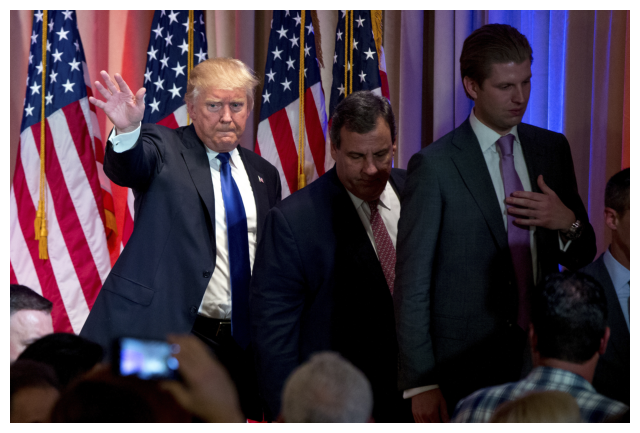

In [35]:
# VOA_EN_NW_2016.05.16.3331907_0
#image_name = "VOA_EN_NW_2016.05.16.3331907_0"

img_path = f"data/sample_imgs/{image_id}.jpg"
image = Image.open(img_path).convert("RGB")

plt.figure(figsize=(8,6))
plt.imshow(image)
plt.axis("off")
plt.show()

## T3 - Verb Classification Model

In [36]:
from t3_verb_classification import ImageEventClassifier as T3Model

event_types = [
    "Life:Die",
    "Movement:Transport",
    "Transaction:Transfer-Money",
    "Conflict:Attack",
    "Conflict:Demonstrate",
    "Contact:Meet",
    "Contact:Phone-Write",
    "Justice:Arrest-Jail"
]


t3_model = T3Model(num_labels=len(event_types)).to(device)
t3_model.load_state_dict(torch.load("models/t3_verb_classification_model.pt", map_location=device))
t3_model.eval()


print("T3 Model loaded successfully.")

/tmp/ipykernel_3053662/38328343.py:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t3_model.load_state_dict(torch.load("models/t3_verb_classification_model.pt", map_locati

T3 Model loaded successfully.


In [38]:
inputs = processor.image_processor(image, return_tensors="pt")["pixel_values"].to(device)

with torch.no_grad():
    logits = t3_model(images=inputs)
    pred_id = torch.argmax(logits, dim=1).item()
    pred_event = event_types[pred_id]

print("======================================")
print("Golden Annotated Event Type:", img_item["event_type"])
print("Predicted Event Type:", pred_event)

Golden Annotated Event Type: Contact:Meet
Predicted Event Type: Contact:Meet


Here we can see that corresponding to the image, and the golden-annotations, it has provided the appropriate event/verb occuring.

## T4 - Argument Role Extraction

In [39]:
from t4_role_classification import ImageArgumentClassifier as T4Model

argument_roles = [
        "Agent",
        "Victim",
        "Instrument",
        "Place",
        "Artifact",
        "Person",
        "Giver",
        "Recipient",
        "Money",
        "Attacker",
        "Target",
        "Demonstrator",
        "Police",
        "Vehicle",
        "Entity"
]

t4_model = T4Model(num_labels=len(argument_roles)).to(device)
t4_model.load_state_dict(torch.load("models/t4_argument_extraction_model.pt", map_location=device))
t4_model.eval()


print("T4 Model loaded successfully.")

/tmp/ipykernel_3053662/830972723.py:22: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  t4_model.load_state_dict(torch.load("models/t4_argument_extraction_model.pt", map_locat

T4 Model loaded successfully.


In [40]:
# Load the image JSON
#img_json = json.load(open("data/m2e2/img_train.json"))  # or img_train.json
#info = img_json[image_name]

role_dict = img_item.get("role", {})

print("Found roles:", list(role_dict.keys()))


Found roles: ['Entity']


In [41]:
predicted_arguments = []

for role, regions in role_dict.items():
    for region in regions:
        _, x1, y1, x2, y2 = region

        # Crop region
        crop = image.crop((x1, y1, x2, y2))

        # Preprocess region
        crop_tensor = processor.image_processor(crop, return_tensors="pt")["pixel_values"].to(device)

        # Predict
        with torch.no_grad():
            logits = t4_model(images=crop_tensor)
            pred_id = torch.argmax(logits, dim=1).item()
            pred_role = argument_roles[pred_id]

        predicted_arguments.append({
            "bbox": (x1, y1, x2, y2),
            "gold_role": role,
            "pred_role": pred_role
        })

# Display results
for arg in predicted_arguments:
    print(f"BBox {arg['bbox']}")
    print(f"   Gold: {arg['gold_role']}")
    print(f"   Pred: {arg['pred_role']}")
    print()


BBox (607, 389, 2221, 2855)
   Gold: Entity
   Pred: Entity

BBox (1997, 651, 3417, 3203)
   Gold: Entity
   Pred: Entity

BBox (3069, 93, 4836, 3351)
   Gold: Entity
   Pred: Entity



Here we can see that for each bounding box that was provided from input, it classified them into the appropriate class. 